In [2]:
import torch
import numpy as np
import seaborn
import yaml
import devinterp
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import copy
from torch import optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.slt.llc import estimate_learning_coeff_with_summary, sample
#from devinterp.slt.mala import MalaAcceptanceRate
from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace

In [3]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Let's define all the hyperparameters
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
on_colab = False
model_width = 64
num_classes = 10
noise_levels = [0.10, 0.15, 0.20]
batch_size = 500
lr = 0.0001
epochs = 2000
model_seed = 42
data_seed = 42

In [5]:
from typing import Union
import numpy as np
import torch
import torch.nn as nn

from devinterp.slt.callback import SamplerCallback


def mala_acceptance_probability(
    prev_point,
    prev_grad,
    prev_loss,
    current_point,
    current_grad,
    current_loss,
    learning_rate,
):
    """
    Calculate the acceptance probability for a MALA transition.

    Args:
    prev_point: The previous point in parameter space.
    prev_grad: Gradient of the prev point in parameter space.
    prev_loss: Loss of the previous point in parameter space.
    current_grad: Gradient of the current point in parameter space.
    current_point: The current point in parameter space.
    current_loss: Loss of the current point in parameter space.
    learning_rate (float): Learning rate of the model.

    Returns:
    float: Acceptance probability for the proposed transition.
    """
    if torch.isnan(current_loss):
        return np.nan
    # Compute the log of the proposal probabilities (using the Gaussian proposal distribution)
    log_q_current_to_prev = -torch.sum(
        (prev_point - current_point - (learning_rate * 0.5 * -current_grad)) ** 2
    ) / (2 * learning_rate)
    log_q_prev_to_current = -torch.sum(
        (current_point - prev_point - (learning_rate * 0.5 * -prev_grad)) ** 2
    ) / (2 * learning_rate)
    acceptance_log_prob = (
        log_q_current_to_prev - log_q_prev_to_current + prev_loss - current_loss
    )
    return min(1.0, torch.exp(acceptance_log_prob))


class MalaAcceptanceRate(SamplerCallback):
    """
    Callback for computing the norm of the gradients of the optimizer / sampler.

    Attributes:
        num_draws (int): Number of samples to draw. (should be identical to param passed to sample())
        num_chains (int): Number of chains to run. (should be identical to param passed to sample())
        num_samples (int): size of dataset passed to sample()
        learning_rate (int): Learning rate of the model.
        device (Union[torch.device, str]): Device to perform computations on, e.g., 'cpu' or 'cuda'.
    """

    def __init__(
        self,
        num_chains: int,
        num_draws: int,
        num_samples: int,
        learning_rate: float,
        device: Union[torch.device, str] = "cpu",
    ):
        self.num_chains = num_chains
        self.num_draws = num_draws
        self.learning_rate = learning_rate
        self.num_samples = num_samples
        self.mala_acceptance_rate = torch.zeros(
            (num_chains, num_draws - 1), dtype=torch.float32
        ).to(device)
        self.device = device
        self.current_params = []
        self.current_grads = []
        self.prev_params = []
        self.prev_grads = []
        self.prev_mala_loss = 0.0

    def __call__(self, chain: int, draw: int, model: nn.Module, loss: float, optimizer):
        self.update(chain, draw, model, loss, optimizer)

    def update(self, chain: int, draw: int, model: nn.Module, loss: float, optimizer):
        # we need the grads & loss from the pass, but the current params are from after the step
        # (so we update those only that after the calculation)
        self.current_grads = optimizer.dws
        # mala acceptance loss is different from pytorch supplied loss
        mala_loss = (
            loss * self.num_samples / np.log(self.num_samples)
        ) + optimizer.elasticity_loss
        # print(
            
        #     loss * self.num_samples / np.log(self.num_samples),
        #     optimizer.elasticity_loss,
        # )
        if draw > 1:
            # print(len(                self.current_grads), len(self.current_params))
            for current_param, current_grad, prev_param, prev_grad in zip(
                self.current_params,
                self.current_grads,
                self.prev_params,
                self.prev_grads,
            ):
                self.mala_acceptance_rate[chain, draw - 1] = (
                    mala_acceptance_probability(
                        prev_param,
                        prev_grad,
                        self.prev_mala_loss,
                        current_param,
                        current_grad,
                        mala_loss,
                        self.learning_rate,
                    )
                )
        # move new -> old, then update new after
        self.prev_params = self.current_params
        self.prev_grads = self.current_grads
        self.prev_mala_loss = mala_loss
        # params update only at the end, as decribed
        self.current_params = [
            param.clone().detach() for param in list(model.parameters())
        ]

    def sample(self):
        return {
            "mala_accept/trace": self.mala_acceptance_rate.cpu().numpy(),
            "mala_accept/mean": np.mean(self.mala_acceptance_rate.cpu().numpy()),
            "mala_accept/std": np.std(self.mala_acceptance_rate.cpu().numpy()),
        }

In [6]:
from typing import Literal, Union
import warnings

import numpy as np
import torch


class SGLD(torch.optim.Optimizer):
    r"""
    Implements Stochastic Gradient Langevin Dynamics (SGLD) optimizer.
    
    This optimizer blends Stochastic Gradient Descent (SGD) with Langevin Dynamics,
    introducing Gaussian noise to the gradient updates. It can also include an
    elasticity term that acts like a special form of weight decay.

    It follows Lau et al.'s (2023) implementation, which is a modification of 
    Welling and Teh (2011) that omits the learning rate schedule and introduces 
    an elasticity term that pulls the weights towards their initial values.

    The equation for the update is as follows:

    $$
    \begin{gathered}
    \Delta w_t=\frac{\epsilon}{2}\left(\frac{\beta n}{m} \sum_{i=1}^m \nabla \log p\left(y_{l_i} \mid x_{l_i}, w_t\right)+\gamma\left(w^_0-w_t\right) - \lambda w_t\right) \\
    +N(0, \epsilon\sigma^2)
    \end{gathered}
    $$

    where $w_t$ is the weight at time $t$, $\epsilon$ is the learning rate, 
    $(\beta n)$ is the inverse temperature (we're in the tempered Bayes paradigm), 
    $n$ is the number of training samples, $m$ is the batch size, $\gamma$ is 
    the elasticity strength, $\lambda$ is the weight decay strength,
    and $\sigma$ is the noise term.

    :param params: Iterable of parameters to optimize or dicts defining parameter groups (required)
    :param lr: Learning rate 
    :param noise_level: Amount of Gaussian noise introduced into gradient updates (default: 1).
    :param weight_decay: L2 regularization term, applied as weight decay (default: 0)
    :param elasticity: Strength of the force pulling weights back to their initial values (default: 0)
    :param temperature: Temperature, either as a float or 'adaptive'(=np.log(num_samples)). (default: adaptive)
    :param bounding_box_size: the size of the bounding box enclosing our trajectory
    :param num_samples: Number of samples to average over (default: 1)
    :param save_noise: whether to store the per-parameter noise during optimization (default: False)

    Example:
        >>> optimizer = SGLD(model.parameters(), lr=0.1, temperature=torch.log(n)/n)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    Note:
        - The `elasticity` term is unique to this implementation and serves to guide the
        weights towards their original values. This is useful for estimating quantities over the local 
        posterior.
        - The `noise_level` is not intended to be changed, except when testing! Doing so will raise a warning.
    """

    def __init__(
        self,
        params,
        lr=0.01,
        noise_level=1.0,
        weight_decay=0.0,
        elasticity=0.0,
        temperature: Union[Literal["adaptive"], float] = "adaptive",
        bounding_box_size=None,
        num_samples=1,
        save_noise=False,
        device='cpu'
    ):
        if noise_level != 1.0:
            warnings.warn(
                "Warning: noise_level in SGLD is unequal to zero, are you intending to use SGD?"
            )
        defaults = dict(
            lr=lr,
            noise_level=noise_level,
            weight_decay=weight_decay,
            elasticity=elasticity,
            temperature=temperature,
            bounding_box_size=bounding_box_size,
            num_samples=num_samples,
            device=device
        )
        super(SGLD, self).__init__(params, defaults)
        self.save_noise = save_noise
        self.noise = None
        self.device = device
        # Save the initial parameters if the elasticity term is set
        for group in self.param_groups:
            if group["elasticity"] != 0 or group["bounding_box_size"] != 0:
                for p in group["params"]:
                    param_state = self.state[p]
                    param_state["initial_param"] = p.data.clone().detach()
            if group["temperature"] == "adaptive":  # TODO: Better name
                group["temperature"] = np.log(group["num_samples"])

    def step(self, closure=None):
        self.noise = []
        self.dws = []
        self.elasticity_loss = torch.tensor([0.0], requires_grad=False, device=self.device)
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                param_state = self.state[p]
                dw = p.grad.data * group["num_samples"] / group["temperature"]

                if group["weight_decay"] != 0:
                    dw.add_(p.data, alpha=group["weight_decay"])
                if group["elasticity"] != 0:
                    initial_param = self.state[p]["initial_param"]
                    initial_param_distance = p.data - initial_param
                    dw.add_(initial_param_distance, alpha=group["elasticity"])
                    self.elasticity_loss += (
                        torch.sum(torch.pow(initial_param_distance.clone().detach(), 2))
                        * group["elasticity"]
                        / 2
                    )
                self.dws.append(dw.clone().detach())

                p.data.add_(dw, alpha=-0.5 * group["lr"])

                # Add Gaussian noise
                noise = torch.normal(
                    mean=0.0, std=group["noise_level"], size=dw.size(), device=dw.device
                )
                if self.save_noise:
                    self.noise.append(noise)
                p.data.add_(noise, alpha=group["lr"] ** 0.5)

                # Rebound if exceeded bounding box size
                if group["bounding_box_size"]:
                    torch.clamp_(
                        p.data,
                        min=param_state["initial_param"] - group["bounding_box_size"],
                        max=param_state["initial_param"] + group["bounding_box_size"],
                    )


In [7]:
## ResNet18 for CIFAR
## Based on: https://gitlab.com/harvard-machine-learning/double-descent/-/blob/master/models/resnet18k.py

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                          nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, init_channels):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(c)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.avpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k, num_classes) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [8]:
# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor()]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Preparing the indices to add label noise and cross-check
num_affected_labels_per_level = []
for i in noise_levels:
    num_noise = int(i * len(trainloader.dataset.data)) # total number of samples to be affected with current noise level
    num_affected_labels_per_level.append(num_noise)
    print(f'For {i} noise level, the total number of noisy labels is: {num_noise}')

For 0.1 noise level, the total number of noisy labels is: 5000
For 0.15 noise level, the total number of noisy labels is: 7500
For 0.2 noise level, the total number of noisy labels is: 10000


In [11]:
all_corrupt_indices = []
affected_labels_per_level = []
all_check_labels = []
level_paths = ['label_noise/ten_percent_label_noise.csv', 'label_noise/fifteen_percent_label_noise.csv', 'label_noise/twenty_percent_label_noise.csv']
for i in range(len(noise_levels)):
    true_targets = trainloader.dataset.targets
    labels = copy.deepcopy(np.array(true_targets))
    np.random.seed(data_seed)
    corrupt_indices = np.random.permutation(len(true_targets))[:num_affected_labels_per_level[i]]
    all_corrupt_indices.append(corrupt_indices)
    check_labels = labels[corrupt_indices].tolist()
    all_check_labels.append(check_labels)
    loaded_labels = pd.read_csv(level_paths[i]).values
    loaded_labels = loaded_labels.squeeze()
    labels[corrupt_indices]= np.array(loaded_labels)
    affected_labels_per_level.append(labels[corrupt_indices])

model = make_resnet18k(model_width, num_classes)

file_path = '/Volumes/New/slt_of_dd/ewdd/'
selected_checkpoint = file_path + 'noise_' + '10' + 'checkpoint-with-noise' + '1999' +'.pth'
checkpoint = torch.load(selected_checkpoint)
model.load_state_dict(checkpoint['model_state'])
model.eval()

EPSILONS = [1e-4, 3e-5, 1e-5, 1e-6, 1e-7]
GAMMAS = [100.0, 1.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}


def estimate_mala_sweeper(model):
    for epsilon in EPSILONS:
        for gamma in GAMMAS:
            mala_estimator = MalaAcceptanceRate(
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                num_samples=len(train_set),
                learning_rate=epsilon,
                device=device,
            )

            result = estimate_learning_coeff_with_summary(
                model,
                trainloader,
                criterion=criterion,
                optimizer_kwargs=dict(
                    lr=epsilon, elasticity=gamma, num_samples=len(train_set)
                ),
                sampling_method=SGLD,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                callbacks=[mala_estimator],
                verbose=False,
                online=True,
            )
            mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
            results[(epsilon, gamma)] = result
            print(
                f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
            )


estimate_mala_sweeper(model)

In [12]:
models = []

for i in range(len(noise_levels)):
  model = make_resnet18k(model_width, num_classes)
  checkpoint= torch.load('ewdd/noise_' + str(int(100*noise_levels[i]))+'checkpoint-with-noise1999.pth', map_location=device)
  model.load_state_dict(checkpoint['model_state'])
  models.append(model)

In [14]:
trainloaders= []
use_test_label_noise = True
for i in range(len(noise_levels)):
    if use_label_noise:
        true_targets = trainloader.dataset.targets
        labels = copy.deepcopy(np.array(true_targets))
        labels[all_corrupt_indices[i]] = affected_labels_per_level[i]
        trainloader.dataset.targets = labels.tolist()
        trainloaders.append(trainloader)

In [13]:
EPSILONS = [3e-5, 1e-5, 1e-6, 1e-7]
GAMMAS = [10.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}

for i in range(len(noise_levels)):
    print(f'Running MALA calibration for ResNet Model with noise_level: {noise_levels[i]}')
    model = models[i]
    trainloader = trainloaders[i]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)

    def estimate_mala_sweeper(model):
        for epsilon in EPSILONS:
            for gamma in GAMMAS:
                mala_estimator = MalaAcceptanceRate(
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    num_samples=len(train_set),
                    learning_rate=epsilon,
                    device=device,
                )

                result = estimate_learning_coeff_with_summary(
                    model,
                    trainloader,
                    criterion=criterion,
                    optimizer_kwargs=dict(
                        lr=epsilon, elasticity=gamma, num_samples=len(train_set)
                    ),
                    sampling_method=SGLD,
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    callbacks=[mala_estimator],
                    verbose=False,
                    online=True,
                )
                mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
                results[(epsilon, gamma)] = result
                print(
                    f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
                )
    estimate_mala_sweeper(model)

Running MALA calibration for ResNet Model with noise_level: 0.1


/Users/sienkadounia/anaconda3/envs/devinterp/lib/python3.9/site-packages/devinterp/slt/llc.py:111: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.llc_stds = self.llcs.std(dim=0)


epsilon 3e-05, gamma 10.0, mala rate: 0.016032064333558083
epsilon 1e-05, gamma 10.0, mala rate: 0.18283604085445404
epsilon 1e-06, gamma 10.0, mala rate: 0.48697400093078613


In [15]:
EPSILONS = [1e-6, 3e-6, 1e-7, 1e-8]
GAMMAS = [10.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}

for i in range(len(noise_levels)):
    print(f'Running MALA calibration for ResNet Model with noise_level: {noise_levels[i]}')
    model = models[i]
    trainloader = trainloaders[i]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)

    def estimate_mala_sweeper(model):
        for epsilon in EPSILONS:
            for gamma in GAMMAS:
                mala_estimator = MalaAcceptanceRate(
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    num_samples=len(train_set),
                    learning_rate=epsilon,
                    device=device,
                )

                result = estimate_learning_coeff_with_summary(
                    model,
                    trainloader,
                    criterion=criterion,
                    optimizer_kwargs=dict(
                        lr=epsilon, elasticity=gamma, num_samples=len(train_set)
                    ),
                    sampling_method=SGLD,
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    callbacks=[mala_estimator],
                    verbose=False,
                    online=True,
                )
                mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
                results[(epsilon, gamma)] = result
                print(
                    f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
                )
    estimate_mala_sweeper(model)

Running MALA calibration for ResNet Model with noise_level: 0.1


/Users/sienkadounia/anaconda3/envs/devinterp/lib/python3.9/site-packages/devinterp/slt/sampler.py:46: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn('You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)')
/Users/sienkadounia/anaconda3/envs/devinterp/lib/python3.9/site-packages/devinterp/slt/llc.py:111: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally a

epsilon 1e-06, gamma 10.0, mala rate: 0.5182739496231079
epsilon 3e-06, gamma 10.0, mala rate: 0.43487128615379333
epsilon 1e-07, gamma 10.0, mala rate: 0.5171772837638855
epsilon 1e-08, gamma 10.0, mala rate: 0.46492984890937805
Running MALA calibration for ResNet Model with noise_level: 0.15
epsilon 1e-06, gamma 10.0, mala rate: 0.46893787384033203
epsilon 3e-06, gamma 10.0, mala rate: 0.42774373292922974


In [ ]:
on_colab = True
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
model_width = 64
num_classes = 10
frac_label_noise = 0.15
mean_value = 0.5
std_value = 0.5
batch_size = 1000
lr = 0.0001
epochs = 1500
model_seed = 42
data_seed = 42

In [ ]:
checkpoints_path = '/Users/sienkadounia/lab/checkpoints/'
#checkpoints_per_path = '/content/gdrive/My Drive/checkpoints_per/'
rlcts_path = '/Users/sienkadounia/lab/checkpoints/rlcts/'

In [ ]:
indice_list = [30, 40, 110, 120, 1990] + list(range(0, 2000, 100))
indice_list.sort()
indice_list

[0,
 30,
 40,
 100,
 110,
 120,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 1990]

In [ ]:
# Loading the rclct_s
ewdd_rlcts = []
checkpoint_name =  'no_burnin_2000_checkpoint' if not use_adam_op else 'no_burnin_2000_adam_checkpoint'
for i in indice_list:
  rlcts = torch.load(rlcts_path + checkpoint_name + str(i)+ '_rlcts.pt') if not use_label_noise else torch.load(rlcts_path + checkpoint_name +str(i) + '_with_noise_rlcts.pt')
  llc = rlcts['llc/mean']
  ewdd_rlcts.append(llc)
ewdd_rlcts

[3415.591552734375,
 6578.77734375,
 7267.32373046875,
 9849.2275390625,
 10009.1318359375,
 10066.6279296875,
 10448.8505859375,
 10436.6640625,
 10367.3203125,
 10349.375,
 10249.3779296875,
 10143.8095703125,
 10030.6123046875,
 9974.2548828125,
 9832.0625,
 9742.6240234375,
 9708.2470703125,
 9582.361328125,
 9576.5419921875,
 9530.7080078125,
 9471.892578125,
 9399.484375,
 9341.4228515625,
 9273.8564453125,
 9205.875]

In [ ]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/System/Library/Fonts/Supplemental/NotoSansBatak-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Arial Italic.ttf',
 '/System/Library/Fonts/AppleSDGothicNeo.ttc',
 '/System/Library/Fonts/Supplemental/Arial Narrow.ttf',
 '/System/Library/Fonts/Supplemental/Trebuchet MS.ttf',
 '/System/Library/Fonts/Supplemental/ITFDevanagari.ttc',
 '/System/Library/Fonts/Supplemental/Verdana Italic.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Georgia.ttf',
 '/System/Library/Fonts/Supplemental/Arial.ttf',
 '/System/Library/Fonts/NotoSansOriya.ttc',
 '/Users/sienkadounia/Library/Fonts/OpenSans-Medium.ttf',
 '/System/Library/Fonts/AquaKana.ttc',
 '/System/Library/Fonts/Optima.ttc',
 '/Users/sienkadounia/Library/Fonts/Times Regular.ttf',
 '/System/Library/Fonts/Supplemental/EuphemiaCAS.ttc',
 '/System/Library/Fonts/SFNSRounded.ttf',
 '/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc',
 '/System/Library/Fonts/Supplemental/C

In [ ]:
golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio
some_multiplier_1 = 1.5
some_multiplier_2 = 1.5

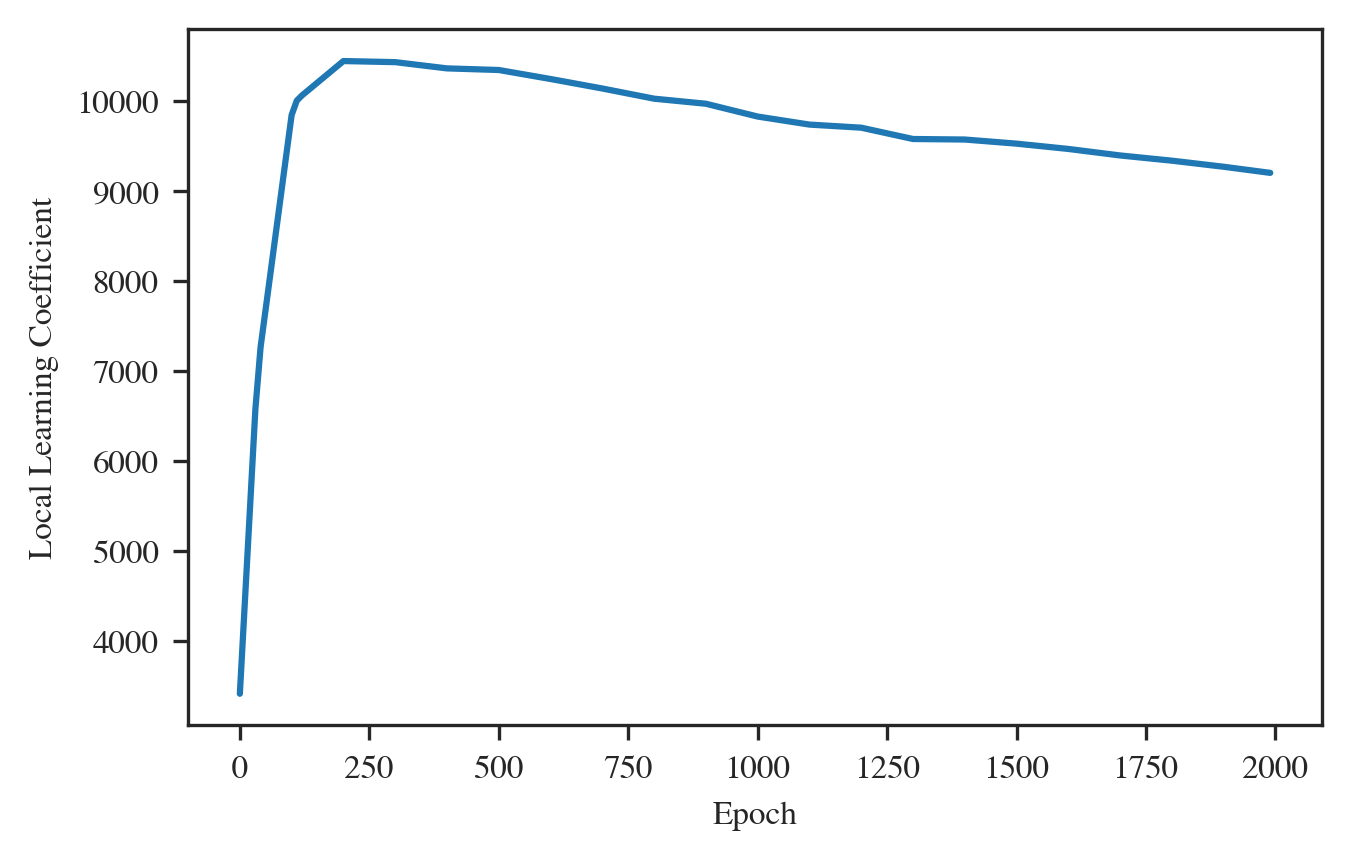

In [ ]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))

plt.plot(indice_list, ewdd_rlcts)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Epoch')
plt.ylabel('Local Learning Coefficient')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "ewdd_rlcts.pdf")
plt.show()

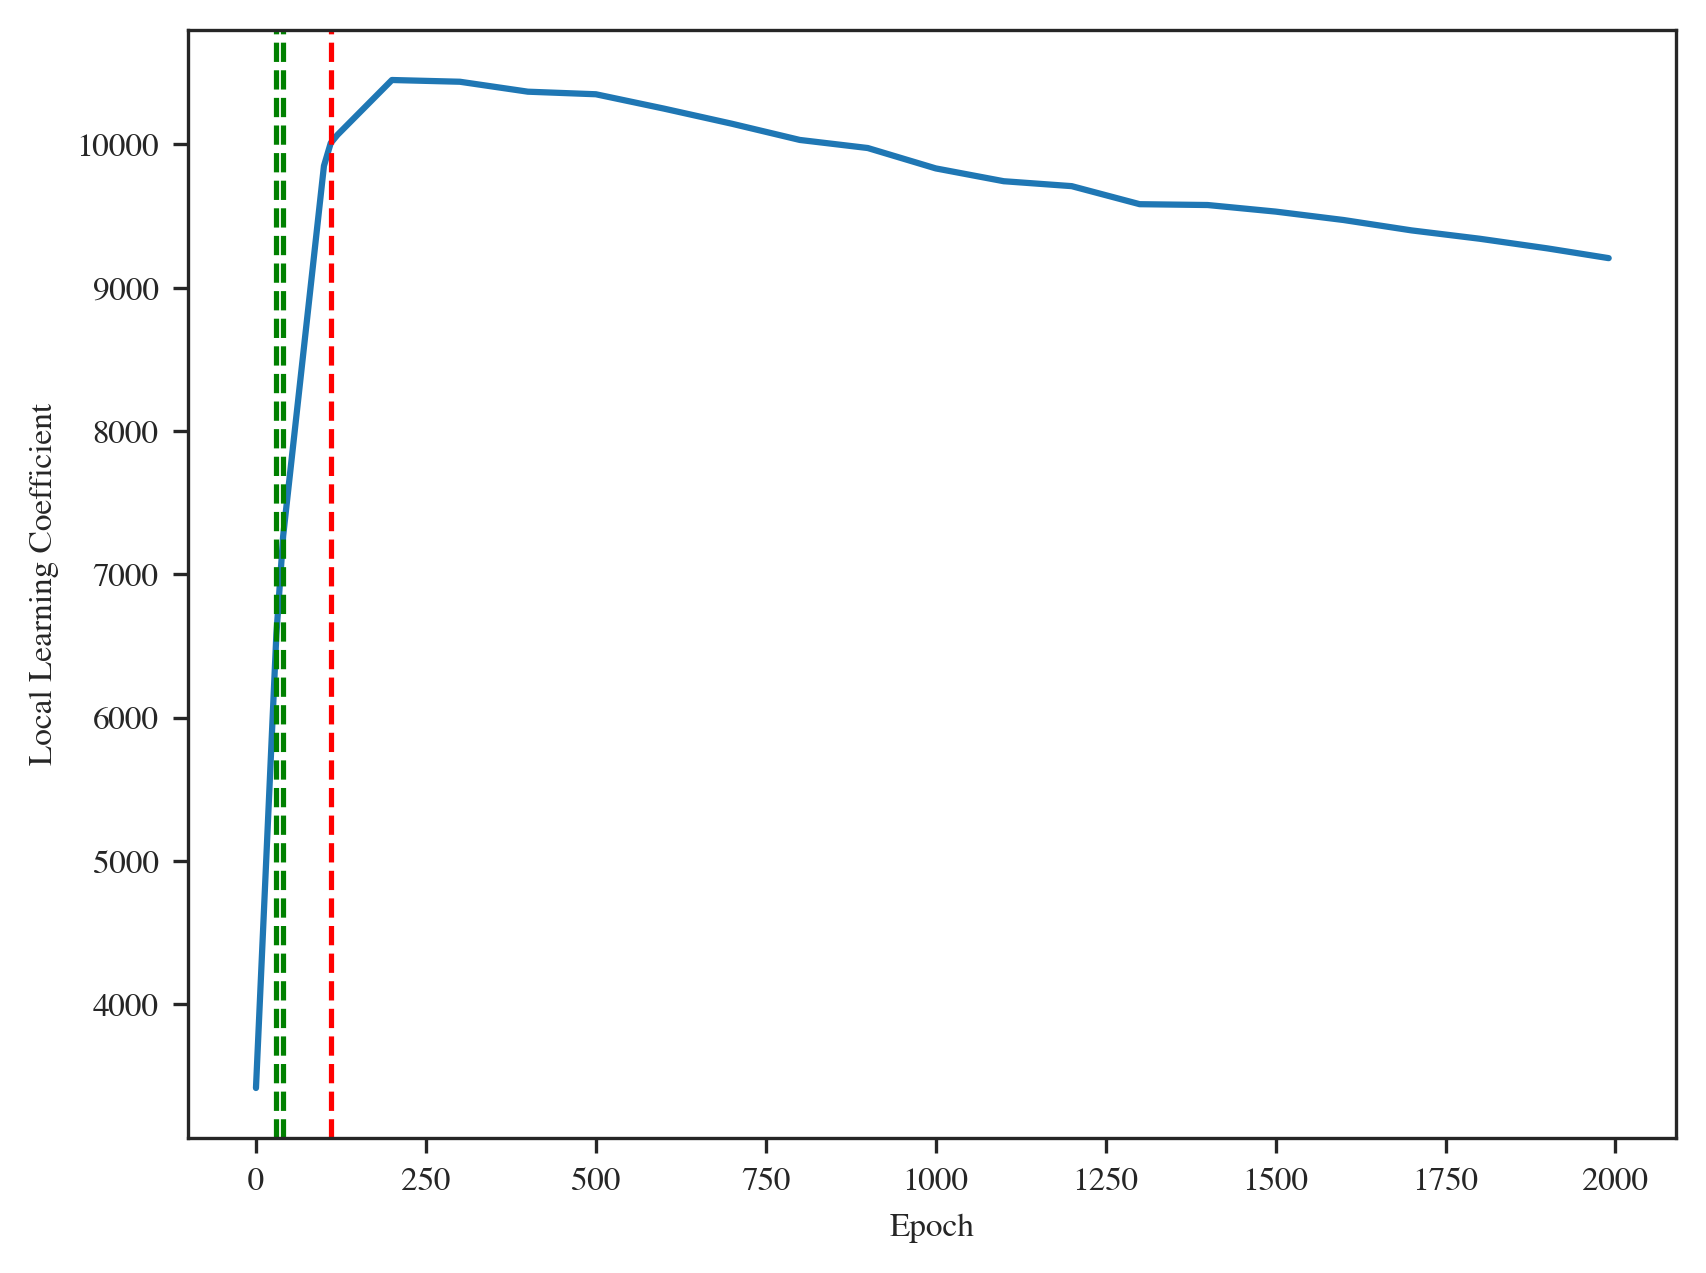

In [ ]:
max_index = 110
d_border_min_index = 30
u_border_min_index = 40


plt.plot(indice_list, ewdd_rlcts)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.axvline(x=d_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=u_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.xlabel('Epoch')
plt.ylabel('Local Learning Coefficient')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "points_ewdd_rlcts.pdf")
plt.show()

In [ ]:
np.argmax(ewdd_rlcts)

6

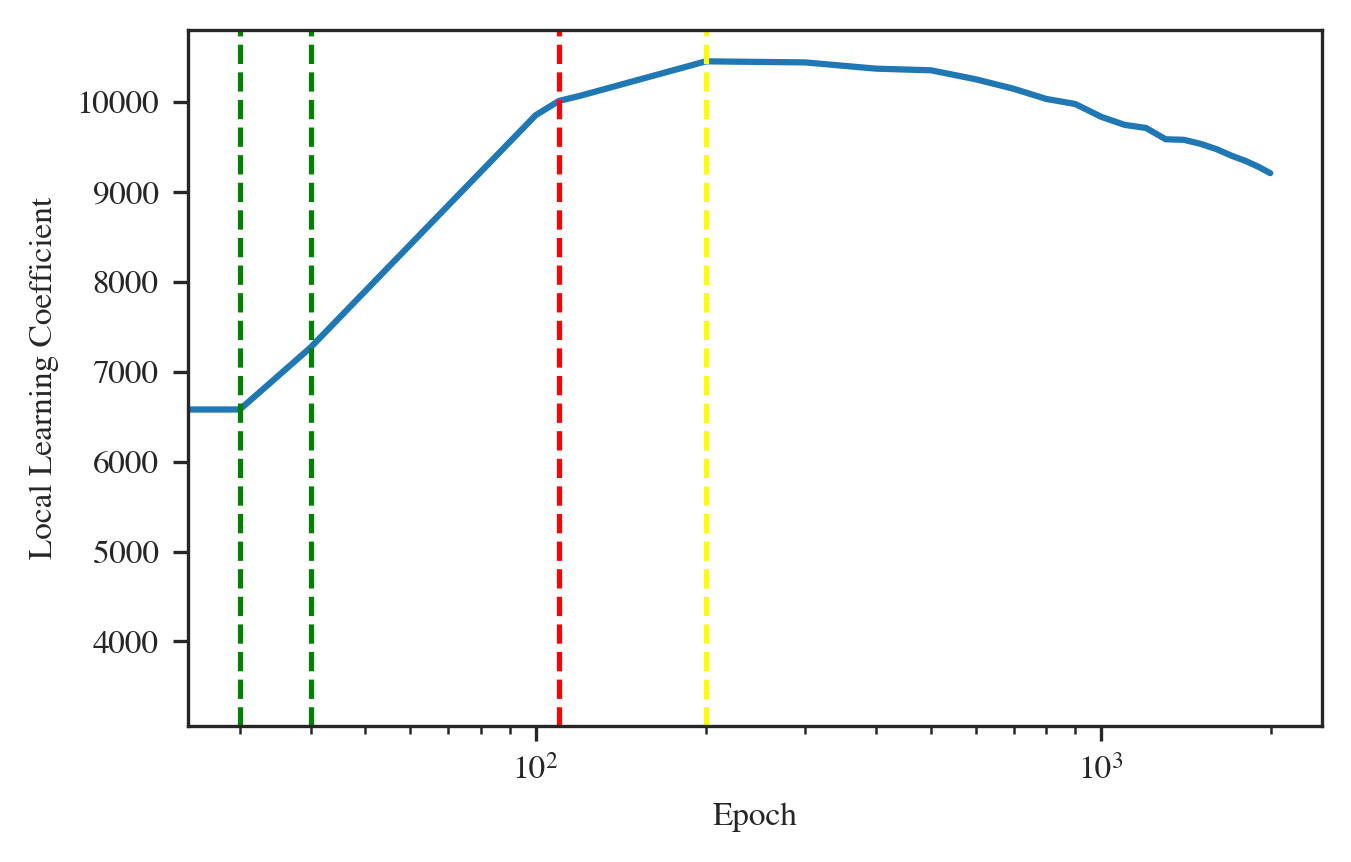

In [ ]:
max_index = 110
d_border_min_index = 30
u_border_min_index = 40
max_llc = 200

plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
plt.plot(indice_list, ewdd_rlcts)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.axvline(x=d_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=u_border_min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_llc, color='yellow', linestyle='--', linewidth = 1.25)
plt.xlabel('Epoch')
plt.xscale('log')
plt.ylabel('Local Learning Coefficient')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "all_points_ewdd_rlcts.pdf")
plt.show()

In [ ]:
trained_model = '2000_'
e_test_error = trained_model + 'test_accs.csv' if not use_label_noise else trained_model + 'test_accs_with_label_noise.csv'
e_test_error = pd.read_csv(checkpoints_path + e_test_error).values
e_train_error = trained_model + 'train_accs.csv' if not use_label_noise else trained_model + 'train_accs_with_label_noise.csv'
e_train_error = pd.read_csv(checkpoints_path + e_train_error).values
e_epochs = np.arange(1, 2001)

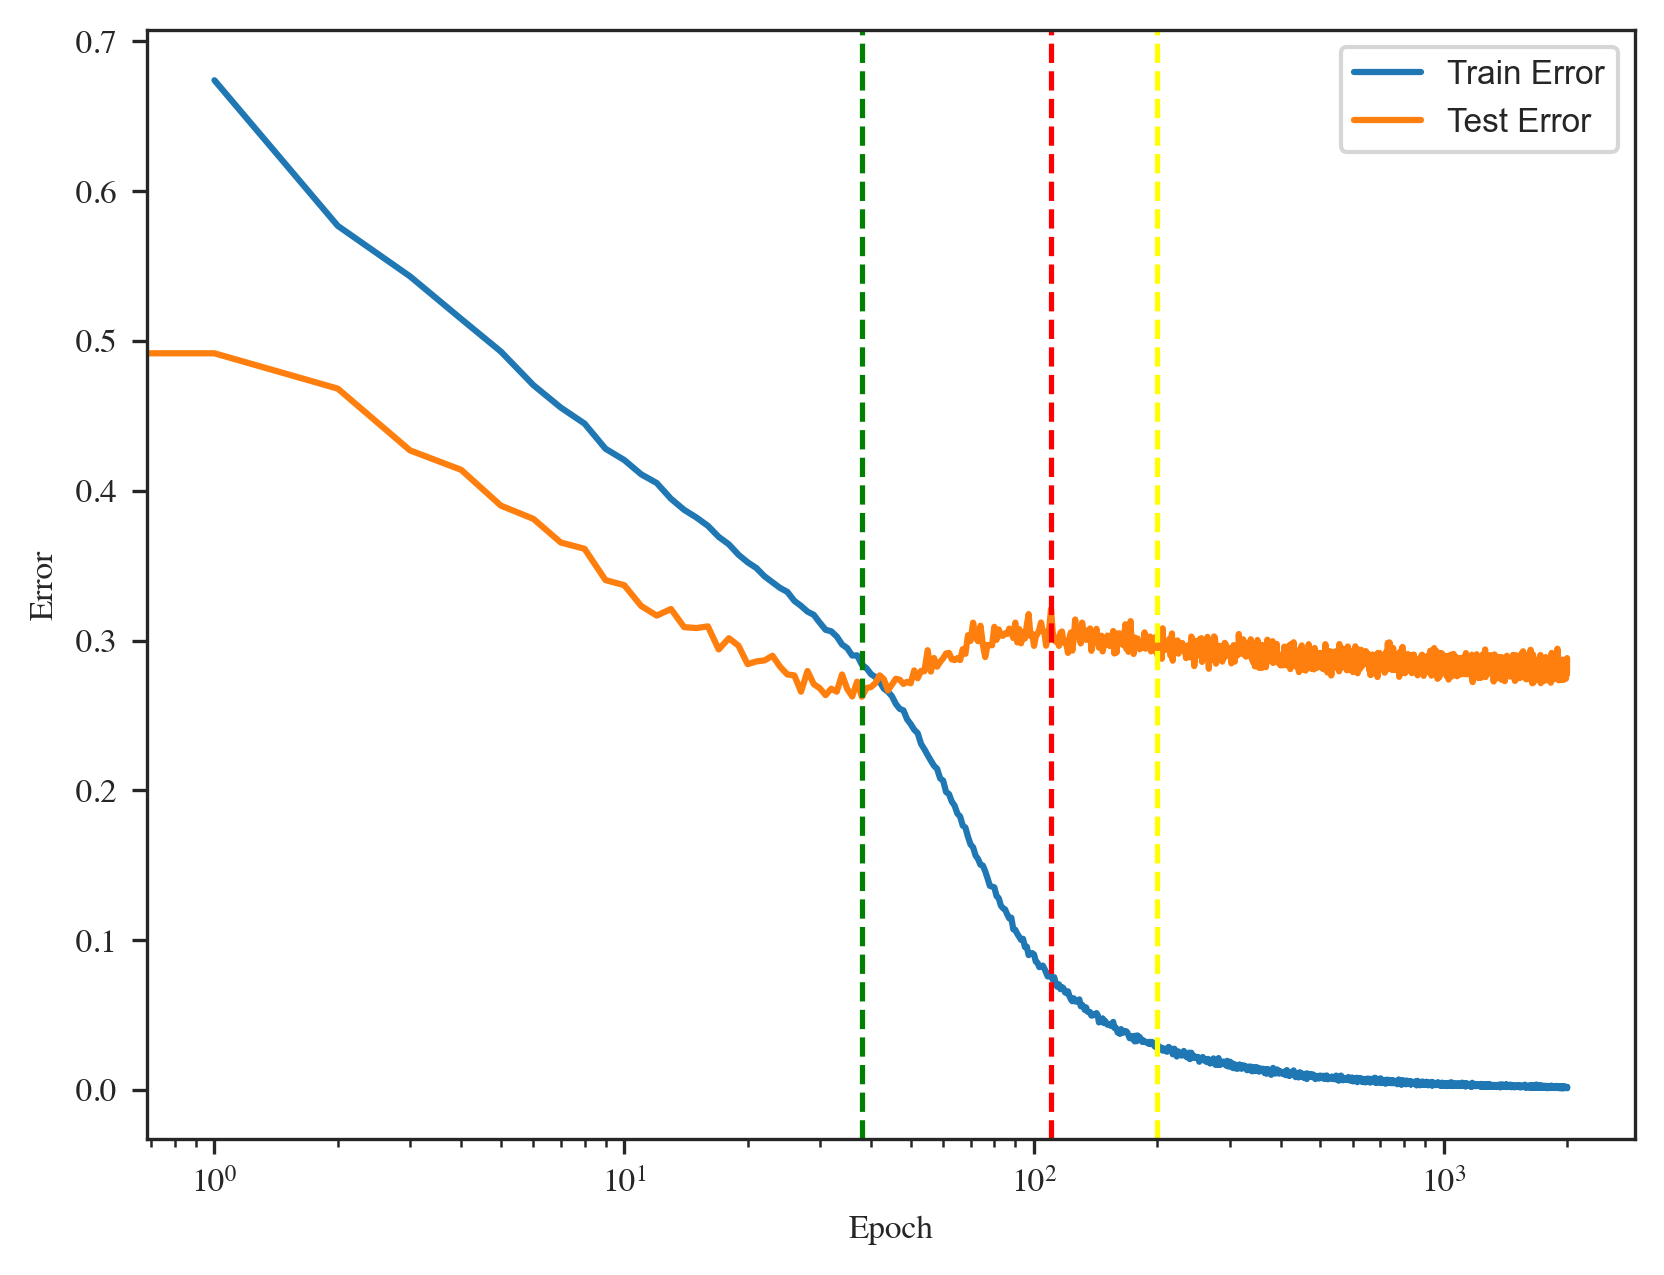

In [ ]:
fig, ax = plt.subplots()
ax.plot(e_epochs, 1-e_train_error, 1-e_test_error)
seaborn.set_style("ticks")
plt.xlabel('Epoch')
plt.xscale('log')
plt.ylabel('Error')
plt.legend(["Train Error", "Test Error"], loc="upper right")
min_index = np.argmin(1-e_test_error)
rest =(1-e_test_error)[min_index:]
max_index = min_index + np.argmax(rest)
ax.axvline(x=min_index, color='green', linestyle='--', linewidth = 1.25)
ax.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_llc, color='yellow', linestyle='--', linewidth = 1.25)
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig(rlcts_path + "ewdd_errors.pdf")
plt.show()